# Illustrating calculation of effective sample size (ESS)

Create two samplers of an underlying $\mathcal{N}(0,\sigma)$ process: an independent sampler, using numpy's built in pseudorandom number generator, and an AR1 process.

The marginal distribution (i.e. across all time points) for the AR1 process is $\mathcal{N}(0,\sqrt{\sigma^2/(1-\rho^2)})$, so we correct its standard deviation (through judicidious choice of $\sigma$) to ensure it is the same as that of the independent sampler.

In [1]:
import numpy as np

def independentSampler(sigma,T):
    return np.random.normal(0,sigma,T)

# to make comparable with independent, sigma = sigma1^2 / (1-rho^2)
def AR1(rho, sigma, T):
    sigma1 = np.sqrt(sigma * (1 - rho**2))
    vX = np.zeros(T)
    for t in range(1,T):
        vX[t] = rho * vX[t-1] + np.random.normal(0,sigma1)
    return vX

## Compare the time course of each of these samplers

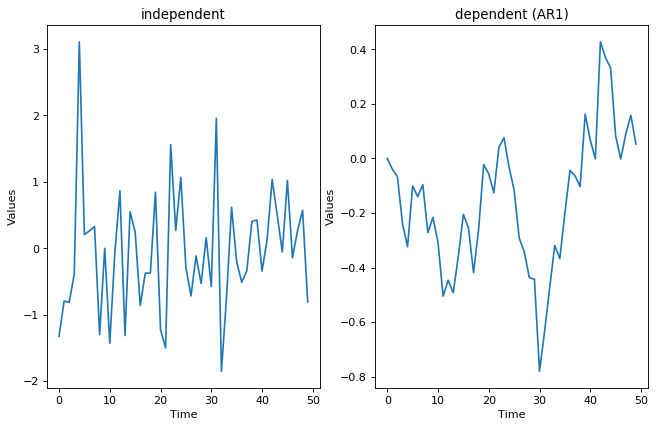

In [2]:
import matplotlib.pyplot as plt

T = 50
sigma = 1
rho = 0.99 # for AR1 only

lXIndependent = independentSampler(sigma,T)
lXDependent = AR1(rho,sigma,T)

plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
# independent
ax1 = plt.subplot(131)
ax1.plot(lXIndependent)
ax1.set_xlabel('Time')
ax1.set_ylabel('Values')
ax1.set_title('independent')

# dependent (AR1)
ax2 = plt.subplot(132)
ax2.plot(lXDependent)
ax2.set_xlabel('Time')
ax2.set_ylabel('Values')
ax2.set_title('dependent (AR1)')

plt.show()

## The marginal distributions (the target $\mathcal{N}(0,\sigma)$) should look similar, although the dependent approximation of the target is poorer

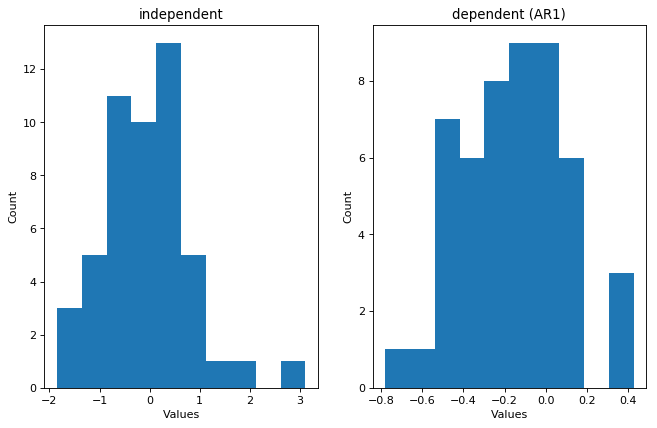

In [3]:
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
# independent
ax1 = plt.subplot(131)
ax1.hist(lXIndependent)
ax1.set_xlabel('Values')
ax1.set_ylabel('Count')
ax1.set_title('independent')

# dependent (AR1)
ax2 = plt.subplot(132)
ax2.hist(lXDependent)
ax2.set_xlabel('Values')
ax2.set_ylabel('Count')
ax2.set_title('dependent (AR1)')

plt.show()

## The reason for the poor fit is the dependence in the AR1 process with $\rho = 0.99$

Use spectral power density to calculate autocorrelation at all lags simultaneously.

In [4]:
def Autocorrelation(x) :
    xp = x-np.mean(x)
    f = np.fft.fft(xp)
    p = np.array([np.real(v)**2+np.imag(v)**2 for v in f])
    pi = np.fft.ifft(p)
    return np.real(pi)[:x.size/2]/np.sum(xp**2)

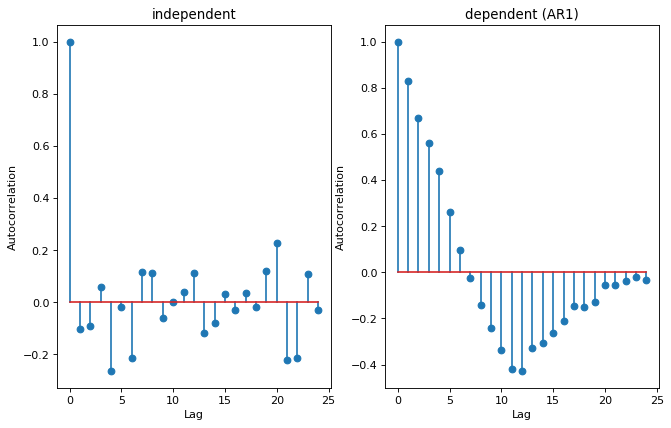

In [5]:
lAutoIndependent = Autocorrelation(lXIndependent)
lAutoDependent = Autocorrelation(lXDependent)

plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
# independent
ax1 = plt.subplot(131)
ax1.stem(lAutoIndependent)
ax1.set_xlabel('Lag')
ax1.set_ylabel('Autocorrelation')
ax1.set_title('independent')

# dependent (AR1)
ax2 = plt.subplot(132)
ax2.stem(lAutoDependent)
ax2.set_xlabel('Lag')
ax2.set_ylabel('Autocorrelation')
ax2.set_title('dependent (AR1)')

plt.show()

## Calculate ESS using,

## $$ESS = \frac{n}{1 + 2 \sum_{t = 1}^{T} \hat{\rho}_t},$$ ##

## where $\hat{\rho}_T$ is the last positive sample autocorrelation.## 

Creating function to find $T$.

In [6]:
def AutocorrelateNegative(lAutocorrelation):
    T = 1
    for a in lAutocorrelation:
        if a < 0:
            return T - 1
        T += 1
    return -1

And function to calculate ESS for a single chain.

In [7]:
def ESS_single(lX):
    lRho = Autocorrelation(lX)
    T = AutocorrelateNegative(lRho)
    n = len(lX)
    ESS = n / (1 + 2 * np.sum(lRho[0:(T-1)]))
    return ESS

Compare ESS for independent and dependent (AR1) series - the equivalent number of independent samples for the dependent sampler is tiny relative to its sample size. We would need roughly 10X more samples from the dependent sampler to explore the posterior to the same degree as the same degree as the independent sampler. This sampler is very inefficient!

In [9]:
ESSIndependent = ESS_single(lXIndependent)
ESSDependent = ESS_single(lXDependent)

print 'independent ESS = ' + str(ESSIndependent)

print 'dependent ESS = ' + str(ESSDependent)

independent ESS = 50.0
dependent ESS = 5.86267060578


## Compare ESS estimator for AR1 with true value (since we know $\rho$ for the AR1).

For large values of $\rho$, I think the above estimator will underestimate.

In [10]:
# geometric progression
def ESSTrueAR1(nSamples, rho):
    ESS = nSamples / (1 + ((2 * rho) / (1 - rho)))
    return ESS

print 'est. dependent (rho = 0.99) ESS = ' + str(ESSDependent)
print 'true dependent (rho = 0.99) ESS = ' + str(ESSTrueAR1(len(lXDependent),rho))

est. dependent (rho = 0.99) ESS = 5.86267060578
true dependent (rho = 0.99) ESS = 0.251256281407


For smaller values of $\rho$ we get a better estimate.

In [12]:
rho = 0.8
lXLowerRho = AR1(rho,sigma,T)

print 'est. dependent (rho = 0.8) ESS = ' + str(ESS_single(lXLowerRho))
print 'true dependent (rho = 0.8) ESS = ' + str(ESSTrueAR1(len(lXLowerRho),rho))

est. dependent (rho = 0.8) ESS = 8.93716702959
true dependent (rho = 0.8) ESS = 5.55555555556
